In [ ]:
!pip install svgwrite
!pip install cairosvg

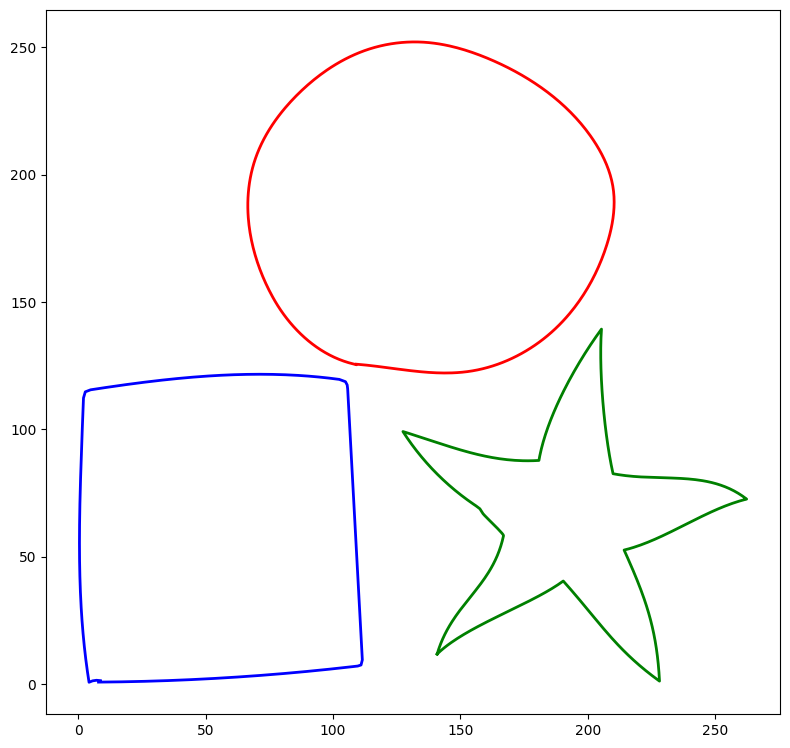

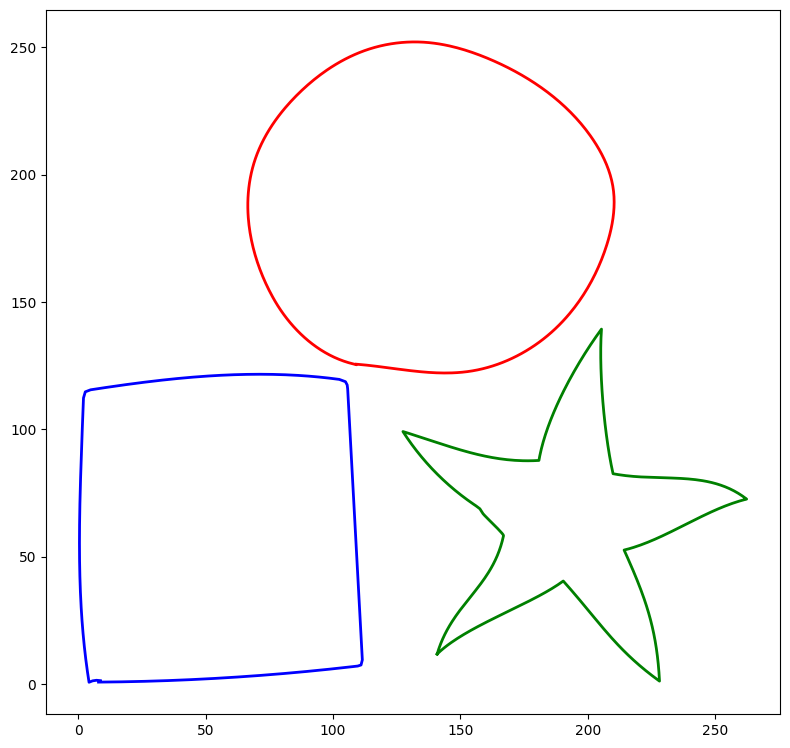

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull, distance_matrix
import svgwrite
import cairosvg

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Shape Detection Functions
from scipy.optimize import minimize

# Line Detection
def detect_line(points, tolerance=1e-2):
    def line_func(params, x):
        a, b = params
        return a * x + b

    x = points[:, 0]
    y = points[:, 1]

    def objective(params):
        return np.sum((line_func(params, x) - y) ** 2)

    initial_guess = [0, np.mean(y)]
    result = minimize(objective, initial_guess)
    line_params = result.x
    residuals = np.abs(line_func(line_params, x) - y)
    return residuals.max() < tolerance, line_params

# Circle Detection
def detect_circle(points, tolerance=1e-2):
    def circle_func(params, x, y):
        x_center, y_center, r = params
        return (x - x_center)**2 + (y - y_center)**2 - r**2

    def objective(params):
        x_center, y_center, r = params
        return np.sum(circle_func(params, points[:, 0], points[:, 1]) ** 2)

    x = points[:, 0]
    y = points[:, 1]
    x_m, y_m = np.mean(x), np.mean(y)
    initial_guess = [x_m, y_m, np.mean(np.sqrt((x - x_m)**2 + (y - y_m)**2))]
    result = minimize(objective, initial_guess)
    circle_params = result.x
    residuals = np.abs(circle_func(circle_params, points[:, 0], points[:, 1]))
    return residuals.max() < tolerance, circle_params

# Ellipse Detection
def detect_ellipse(points, tolerance=1e-2):
    def ellipse_func(params, x, y):
        a, b, x_center, y_center, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        X = cos_theta * (x - x_center) + sin_theta * (y - y_center)
        Y = -sin_theta * (x - x_center) + cos_theta * (y - y_center)
        return (X / a)**2 + (Y / b)**2 - 1

    def objective(params):
        a, b, x_center, y_center, theta = params
        return np.sum(ellipse_func(params, points[:, 0], points[:, 1]) ** 2)

    x = points[:, 0]
    y = points[:, 1]
    x_m, y_m = np.mean(x), np.mean(y)
    initial_guess = [np.std(x), np.std(y), x_m, y_m, 0]
    result = minimize(objective, initial_guess)
    ellipse_params = result.x
    residuals = np.abs(ellipse_func(ellipse_params, points[:, 0], points[:, 1]))
    return residuals.max() < tolerance, ellipse_params

# Rectangle Detection
def detect_rectangle(points, tolerance=1e-2):
    hull = ConvexHull(points)
    if len(hull.vertices) == 4:
        rect_points = hull.points[hull.vertices]
        dists = np.linalg.norm(np.diff(np.vstack([rect_points, rect_points[0]]), axis=0), axis=1)
        if np.std(dists) / np.mean(dists) < tolerance:
            return True, hull
    return False, None

# Polygon Detection
def detect_polygon(points, num_sides, tolerance=1e-2):
    hull = ConvexHull(points)
    if len(hull.vertices) == num_sides:
        polygon_points = hull.points[hull.vertices]
        dists = np.linalg.norm(np.diff(np.vstack([polygon_points, polygon_points[0]]), axis=0), axis=1)
        if np.std(dists) / np.mean(dists) < tolerance:
            return True, hull
    return False, None

# Star Detection
def detect_star(points, num_points, tolerance=1e-2):
    hull = ConvexHull(points)
    if len(hull.vertices) == num_points * 2:
        star_points = hull.points[hull.vertices]
        dists = np.linalg.norm(np.diff(np.vstack([star_points, star_points[0]]), axis=0), axis=1)
        long_short_pattern = [dists[i] > dists[i-1] if i % 2 == 1 else dists[i] < dists[i-1] for i in range(1, len(dists))]
        if all(long_short_pattern):
            return True, hull
    return False, None


# Shape Regularization Functions
def regularize_line(points, params):
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    line_points = np.array([[x_min, params[0] * x_min + params[1]],
                            [x_max, params[0] * x_max + params[1]]])
    return line_points

def regularize_circle(params):
    x_center, y_center, r = params
    theta = np.linspace(0, 2*np.pi, 100)
    circle_points = np.array([x_center + r * np.cos(theta), y_center + r * np.sin(theta)]).T
    return circle_points

def regularize_ellipse(params):
    a, b, x_center, y_center, theta = params
    t = np.linspace(0, 2*np.pi, 100)
    x = x_center + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    y = y_center + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    ellipse_points = np.column_stack((x, y))
    return ellipse_points

def regularize_rectangle(hull):
    rectangle_points = hull.points[hull.vertices]
    return np.vstack([rectangle_points, rectangle_points[0]])

def regularize_polygon(hull):
    polygon_points = hull.points[hull.vertices]
    return np.vstack([polygon_points, polygon_points[0]])

def regularize_star(hull):
    star_points = hull.points[hull.vertices]
    return np.vstack([star_points, star_points[0]])

# Regularize Shapes
def regularize_shapes(paths_XYs):
    regularized_paths = []
    for shape in paths_XYs:
        regularized_shape = []
        for path in shape:
            is_line, line_params = detect_line(path)
            if is_line:
                regularized_shape.append(regularize_line(path, line_params))
                continue

            is_circle, circle_params = detect_circle(path)
            if is_circle:
                regularized_shape.append(regularize_circle(circle_params))
                continue

            is_ellipse, ellipse_params = detect_ellipse(path)
            if is_ellipse:
                regularized_shape.append(regularize_ellipse(ellipse_params))
                continue

            is_rectangle, rectangle_hull = detect_rectangle(path)
            if is_rectangle:
                regularized_shape.append(regularize_rectangle(rectangle_hull))
                continue

            is_polygon, polygon_hull = detect_polygon(path, num_sides=6)  # Assuming regular hexagon
            if is_polygon:
                regularized_shape.append(regularize_polygon(polygon_hull))
                continue

            is_star, star_hull = detect_star(path, num_points=5)  # Assuming 5-pointed star
            if is_star:
                regularized_shape.append(regularize_star(star_hull))
                continue

            regularized_shape.append(path)  # No regularization applied
        regularized_paths.append(regularized_shape)
    return regularized_paths

# SVG Export
def polylines2svg(paths_XYs, svg_path, colors):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colors[i % len(colors)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H, output_width=fact*W, output_height=fact*H, background_color='white')
    return

# Example Usage
csv_path = 'isolated.csv'
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
paths_XYs = read_csv(csv_path)

# Regularize the shapes
regularized_paths = regularize_shapes(paths_XYs)

# Plot and visualize the original and regularized shapes
plot(paths_XYs, colors)
plot(regularized_paths, colors)

# Save to SVG and PNG
polylines2svg(regularized_paths, 'regularized_shapes.svg', colors)


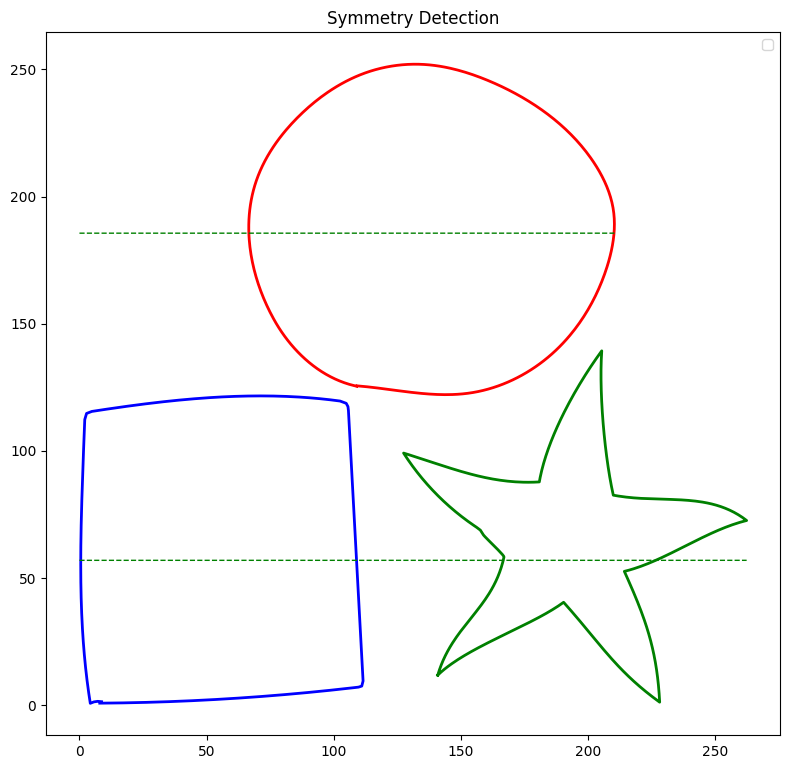

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from itertools import combinations
from sklearn.metrics.pairwise import euclidean_distances


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, colors, title=''):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

def find_reflection_symmetry(points, tolerance=1e-2):
    def calculate_reflection_line(p1, p2):
        midpoint = (p1 + p2) / 2
        if p2[0] != p1[0]:
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            perpendicular_slope = -1 / slope
        else:
            perpendicular_slope = np.inf
        return midpoint, perpendicular_slope

    def is_point_symmetric(point, line_midpoint, perpendicular_slope):
        if perpendicular_slope == np.inf:  # vertical line
            return np.abs(point[0] - line_midpoint[0]) < tolerance
        elif perpendicular_slope == 0:  # horizontal line
            return np.abs(point[1] - line_midpoint[1]) < tolerance
        else:
            reflection_x = ((1 - perpendicular_slope**2) * point[0] + 2 * perpendicular_slope * point[1]) / (1 + perpendicular_slope**2)
            reflection_y = ((1 - perpendicular_slope**2) * point[1] + 2 * perpendicular_slope * point[0]) / (1 + perpendicular_slope**2)
            return np.sqrt((reflection_x - point[0])**2 + (reflection_y - point[1])**2) < tolerance

    symmetric_lines = []
    hull = ConvexHull(points)

    for i, j in combinations(hull.vertices, 2):
        p1, p2 = points[i], points[j]
        midpoint, perpendicular_slope = calculate_reflection_line(p1, p2)

        if all(is_point_symmetric(point, midpoint, perpendicular_slope) for point in points):
            symmetric_lines.append((midpoint, perpendicular_slope))

    return symmetric_lines

def find_all_axes_symmetry(points, tolerance=1e-2):
    def is_symmetric_across_axis(points, axis):
        if axis == 'x':
            return np.allclose(points[:, 1], -points[:, 1], atol=tolerance)
        elif axis == 'y':
            return np.allclose(points[:, 0], -points[:, 0], atol=tolerance)
        elif axis == 'xy':
            return np.allclose(points[:, 0] + points[:, 1], 0, atol=tolerance) and np.allclose(points[:, 0] - points[:, 1], 0, atol=tolerance)
        elif axis == 'yx':
            return np.allclose(points[:, 0] + points[:, 1], 0, atol=tolerance) and np.allclose(points[:, 0] - points[:, 1], 0, atol=tolerance)

    axes = ['x', 'y', 'xy', 'yx']
    symmetric_axes = []

    for axis in axes:
        if is_symmetric_across_axis(points, axis):
            symmetric_axes.append(axis)

    return symmetric_axes

def find_rotational_symmetry(points, tolerance=1e-2):
    def is_rotationally_symmetric(points, center, angle, tolerance):
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        rotated_points = np.array([
            [
                center[0] + (x - center[0]) * cos_theta - (y - center[1]) * sin_theta,
                center[1] + (x - center[0]) * sin_theta + (y - center[1]) * cos_theta
            ]
            for x, y in points
        ])
        return np.all(np.linalg.norm(euclidean_distances(points, rotated_points), axis=1) < tolerance)

    center = np.mean(points, axis=0)
    angles = np.linspace(0, 2 * np.pi, 360, endpoint=False)
    return [angle for angle in angles if is_rotationally_symmetric(points, center, angle, tolerance)]

def visualize_symmetry(paths_XYs, colors):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    W, H = 0, 0
    for i, XYs in enumerate(paths_XYs):
        c = colors[i % len(colors)]
        for XY in XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

            # Detect and visualize symmetry
            symmetric_lines = find_reflection_symmetry(XY)
            for midpoint, slope in symmetric_lines:
                if slope == np.inf:  # vertical line
                    ax.plot([midpoint[0], midpoint[0]], [0, H], 'g--', linewidth=1)
                elif slope == 0:  # horizontal line
                    ax.plot([0, W], [midpoint[1], midpoint[1]], 'g--', linewidth=1)
                else:
                    x = np.array([0, W])
                    y = midpoint[1] + slope * (x - midpoint[0])
                    ax.plot(x, y, 'g--', linewidth=1)

            symmetric_axes = find_all_axes_symmetry(XY)
            for axis in symmetric_axes:
                if axis == 'x':
                    ax.plot([0, W], [0, 0], 'r--', linewidth=1, label='x-axis symmetry')
                elif axis == 'y':
                    ax.plot([0, 0], [0, H], 'r--', linewidth=1, label='y-axis symmetry')
                elif axis == 'xy':
                    ax.plot([0, W], [0, W], 'b--', linewidth=1, label='y=x symmetry')
                elif axis == 'yx':
                    ax.plot([0, W], [H, 0], 'b--', linewidth=1, label='y=-x symmetry')

            rotational_angles = find_rotational_symmetry(XY)
            for angle in rotational_angles:
                x = np.array([0, W])
                y = np.array([0, H]) * np.tan(angle)
                ax.plot(x, y, 'b--', linewidth=1, label=f'Rotation angle: {angle:.2f}')

    ax.set_aspect('equal')
    ax.set_title('Symmetry Detection')
    plt.legend()
    plt.show()

# Example Usage
csv_path = 'isolated.csv'
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
paths_XYs = read_csv(csv_path)

# Visualize symmetry in the shapes
visualize_symmetry(paths_XYs, colors)


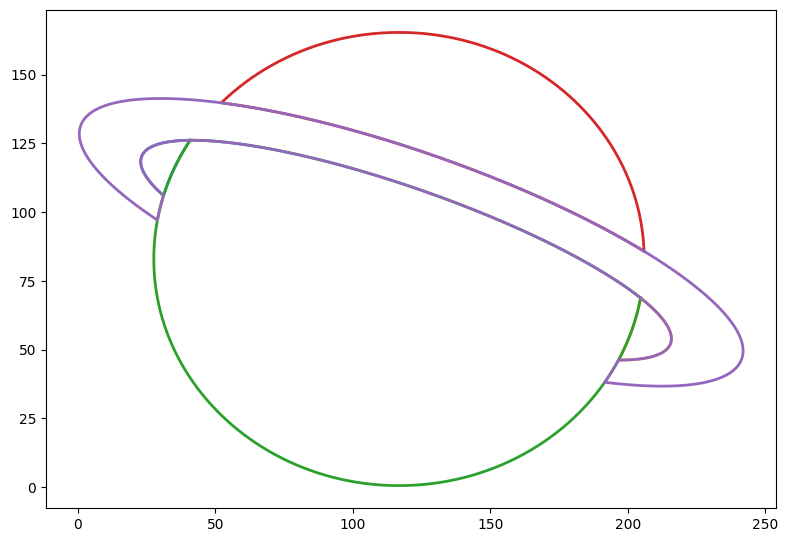

SVG file saved as 'completed_output.svg'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import svgwrite
import cairosvg

def read_csv(csv_path):
    try:
        np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
        path_XYs = []
        for i in np.unique(np_path_XYs[:, 0]):
            npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
            XYs = []
            for j in np.unique(npXYs[:, 0]):
                XY = npXYs[npXYs[:, 0] == j][:, 1:]
                XYs.append(XY)
            path_XYs.append(XYs)
        return path_XYs
    except FileNotFoundError:
        print(f"Error: The file {csv_path} was not found.")
        return None

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            XY = np.array(XY)  # Ensure it's a NumPy array
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def fit_bezier_curve(points):
    """Fit a Bézier curve to a set of points."""
    # Ensure points are in a numpy array
    points = np.array(points)

    # Fit a Bézier spline to the points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, per=False)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck)

    # Return fitted Bézier curve points
    return np.vstack([x_new, y_new]).T

def complete_curve(paths_XYs):
    """Complete curves by fitting Bézier curves to gaps."""
    completed_paths = []
    for XYs in paths_XYs:
        completed_XYs = []
        for XY in XYs:
            if len(XY) < 2:
                completed_XYs.append(XY)
                continue

            # Check if the curve is open or closed
            if np.allclose(XY[0], XY[-1]):
                completed_XYs.append(XY)
            else:
                # Fit Bézier curve to the polyline
                completed_curve = fit_bezier_curve(XY)
                completed_XYs.append(completed_curve)

        completed_paths.append(completed_XYs)
    return completed_paths

def save_svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        for XY in path:
            path_data = f"M{XY[0, 0]},{XY[0, 1]} "
            path_data += " ".join([f"L{p[0]},{p[1]}" for p in XY[1:]])
            if np.allclose(XY[0], XY[-1]):
                path_data += " Z"
            group.add(dwg.path(d=path_data, fill='none', stroke='black', stroke_width=2))
    dwg.add(group)
    dwg.save()

def main():
    # Step 1: Specify the CSV file path
    csv_path = 'occlusion2.csv'  # Ensure this path is correct

    # Step 2: Read the CSV file
    paths_XYs = read_csv(csv_path)
    if paths_XYs is None:
        return

    # Step 3: Perform curve completion
    completed_paths = complete_curve(paths_XYs)

    # Step 4: Plot the completed curves
    plot(completed_paths)

    # Step 5: Save the completed curves as an SVG file
    save_svg(completed_paths, 'completed_output.svg')
    print("SVG file saved as 'completed_output.svg'.")

# Run the main function
main()
